# __Basic Financial Market Simulation for a Single Instrument 1.0__

In economics, there is a fundamental principle of __supply and demand__ that explains how prices are determined in markets through the interaction of what people want to buy and sell. In this notebook, we will use this principle to create a simplified model of the market for a single financial instrument. More precisely, this notebook demonstrates a simulation of traders who buy and sell from each other over time.

### __Contents__

- Basic Simulation Model
- Recap
- Cleaning Up
- Fees
- Initial Trader Wealth
- Tracking Trader Wealth
- Interpreting Our Results
- Varying When a Trader Trades
- Varying How Many Shares a Trader Trades
- Refining Price Changes
- The End (for now)

### __Basic Simulation Model__

First, we define a Trader class used to represent all investors/traders in this model. To keep our model simple, a few assumptions are made:

- Each trader follows one of three strategies, which they implement at every time interval:
    1. Random: equal chance of buy, sell and hold
    2. Momentum: buy when price rises, sell when price falls
    3. Contrarian: buy when price falls, sell when price rises

and

- Each trader has three attributes:
    1. Strategy: random, momentum, or contrarian
    2. Cash: amount of cash
    3. Shares: number of shares

Each trader, at each time-step, needs to decide whether they want to buy, sell, or hold. The decision made depends on the individual trader's strategy, on the current price of the instrument, as well as its price at the previous time-step.

In [109]:
# Define and create a Trader class that will be used to represent all traders in this model.

import random

class Trader:
    
    def __init__(self, strategy):
        self.strategy = strategy
        # Each trader begins with 3000 units of cash and 100 shares
        self.cash = 3000
        self.shares = 100

    def decide(self, current_price, price_history):
        if self.strategy == 'random':
            return random.choice(['buy', 'sell', 'hold'])
        elif self.strategy == 'momentum':
            if (current_price > price_history[-1]): # if price rose
                return 'buy'
            elif (current_price < price_history[-1]): # if price fell
                return 'sell'
            else:
                return 'hold'
        elif self.strategy == 'contrarian':
            if (current_price > price_history[-1]):
                return 'sell'
            elif (current_price < price_history[-1]):
                return 'buy'
            else:
                return 'hold'

As a start, let's begin with 50 investors. Each of them are created with their respective strategies selected randomly.

In [110]:
# Create traders

def create_traders(num_traders):    
    traders = [Trader(random.choice(['random', 'momentum', 'contrarian'])) for _ in range(num_traders)]
    return traders

traders = create_traders(50)

# Count the number of different traders and print

def print_trader_counts(traders):
    ran_trader_count = 0
    mom_trader_count = 0
    con_trader_count = 0

    for trader in traders:
        if trader.strategy == 'random': ran_trader_count += 1
        elif trader.strategy == 'momentum': mom_trader_count += 1
        else: con_trader_count += 1

    print(f'Random traders: {ran_trader_count}')
    print(f'Momentum traders: {mom_trader_count}')
    print(f'Contrarian trader: {con_trader_count}')

print_trader_counts(traders)

Random traders: 20
Momentum traders: 15
Contrarian trader: 15


Now that we have our traders and we know how they will make decisions, we need to implement these decisions.

Suppose the initial price of our instrument is 30, and the simulation is run for 1000 time-steps.

In our simplified model, the price will fluctuate based on a basic implementation of supply and demand. If more traders are buying than selling, the price rises. If more traders are selling than buying, the price falls. To prevent a scenario with unlimited liquidity, we also check that each buyer has a seller, and vice versa. This is important, because financial markets are a zero-sum game. Without someone willing to sell, no-one can buy. 

Therefore, we count the number of traders intent on buying and selling, and implement trades until we run out of either buyers or sellers. The number of remaining buyers or sellers is then used to determine the demand/supply for each time-step, which is used to adjust the price for the next time step. In our model, the price will either increase/decrease by 1% at each time interval based on whether demand is greater than supply, or vice versa*.

In the code below, you'll notice the use of the __random.shuffle__ method on our respective buyers and sellers. Since we're looping from the first to the last trader in terms of when they were created, this is simply to ensure that the first traders don't always trade first.

_*For now we use a static 1% change in price, but we will implement proportional price adjustments later on._

In [111]:
# Set initial price of instrument

price = 30
price_history = [price]

# Simulate for a specific number of time steps

def run_sim(traders, price, price_history, time_steps):
    for _ in range(time_steps):
        buy_orders = [] # stores traders deciding to buy
        sell_orders = [] # stores traders deciding to sell

        for trader in traders:
            decision = trader.decide(price, price_history)
            # check decision and whether trader has enough cash to buy, or enough shares to sell
            if (decision == 'buy') and (trader.cash >= price):
                buy_orders.append(trader)
            elif (decision == 'sell') and (trader.shares > 0):
                sell_orders.append(trader)

        # randomly rearrange the order lists so that the first traders aren't always trading first
        random.shuffle(buy_orders)
        random.shuffle(sell_orders)

        # find number of buyers and sellers that match (eg. 10 buyers:7 sellers -> num_match = 7)
        num_matched = min(len(buy_orders), len(sell_orders))

        # redistribute cash and share values to traders (execute trades)
        for i in range(num_matched):
            buy_orders[i].cash -= price # buyer loses money
            buy_orders[i].shares += 1 # buyer gains share
            sell_orders[i].cash += price # seller gains money
            sell_orders[i].shares -= 1 # seller loses share

        # find number of buyers/sellers that couldn't trade -> this amount represents demand/supply
        
        unmatched_buyers = len(buy_orders) - num_matched
        unmatched_sellers = len(sell_orders) - num_matched

        if unmatched_buyers > unmatched_sellers:
            price *= 1.01 # increase by 1%
        elif unmatched_sellers > unmatched_buyers:
            price *= 0.99 # decrease by 1%

        # round the price value to two decimals to prevent floating-point errors 
        price = round(price, 2)

        # add new price to price history list
        price_history.append(price)
    
    # return price history to plot
    return price_history

# run the simulation and get price history
ph = run_sim(traders, price, price_history, 1000)

Having simulated 1000 time-steps worth of trades, let's see how the price of our instrument has fluctuated.

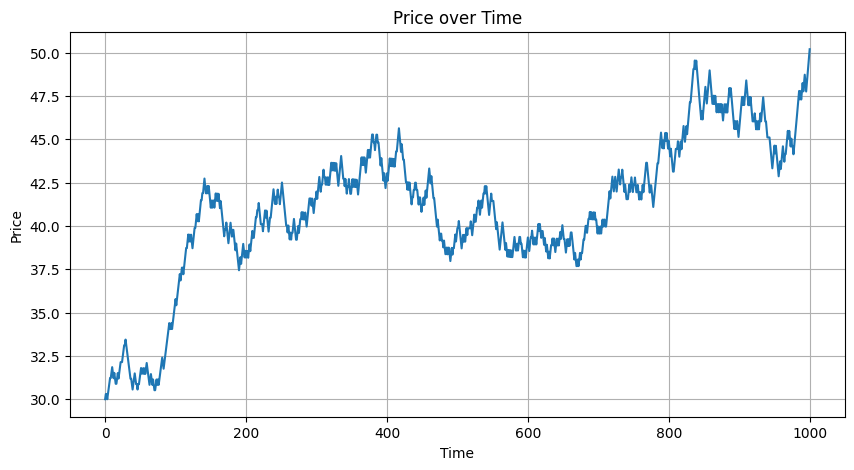

In [112]:
import matplotlib.pyplot as plt

def plot_price(price_history):
    plt.figure(figsize=(10, 5))
    plt.plot(price_history)
    plt.title("Price over Time")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

plot_price(ph)

### __Recap__

Now that we have a simplistic implementation of a financial market, let's add some complexity to make it more realistic.

First, a recap of the main functions and objects we have created so far:

- __Trader__ -> a class used to store each trader's strategy, cash and shares, as well as their decision-making logic
- __create_traders(num_traders)__ -> function that instantiates a variable number of traders, each with a different strategy
- __print_trader_counts(traders)__ -> function that prints how many traders exist for each strategy
- __run_sim(traders, price, price_history, time_steps)__ -> function that simulates trades between our traders, with price updates at each time-step for a variable number of time-steps
- __plot_price(price_history)__ -> function that plots the price history of our instrument

Below is a another simulation with the following parameters: 100 traders, initial instrument price of 100, and we are simulating over 1000 time steps.

Random traders: 31
Momentum traders: 35
Contrarian trader: 34


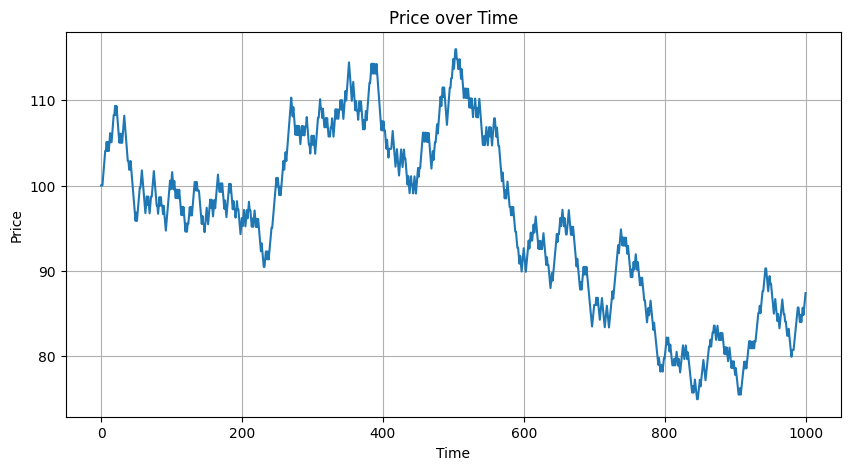

In [113]:
traders = create_traders(100)
print_trader_counts(traders)
ph = run_sim(traders, 100, [100], 1000)
plot_price(ph)

### __Cleaning Up__

Before we start adding more features, let's first clean up our main __run_sim__ function by creating some sub-functions that will replace all that occurs within the simulation. We will be adding several new aspects to our model, and cleaning up will help us going forward.



In [114]:
# determine who can/wants to buy and who can/wants to sell
def initiate_orders(traders, price, price_history):
    buy_orders = []
    sell_orders = []

    for trader in traders:
        decision = trader.decide(price, price_history)
        if (decision == 'buy') and (trader.cash >= price):
            buy_orders.append(trader)
        elif (decision == 'sell') and (trader.shares > 0):
            sell_orders.append(trader)

    random.shuffle(buy_orders)
    random.shuffle(sell_orders)
        
    return buy_orders, sell_orders

# redistribute cash and share values to traders (execute trades)
def execute_trades(num_matched, buy_orders, sell_orders):
    for i in range(num_matched):
        buy_orders[i].cash -= price
        buy_orders[i].shares += 1
        sell_orders[i].cash += price
        sell_orders[i].shares -= 1
    
    return buy_orders, sell_orders

# adjust the price based on unmatched supply/demand
def adjust_price(buy_orders, sell_orders, num_matched, price, price_history):
    unmatched_buyers = len(buy_orders) - num_matched
    unmatched_sellers = len(sell_orders) - num_matched

    if unmatched_buyers > unmatched_sellers:
        price *= 1.01
    elif unmatched_sellers > unmatched_buyers:
        price *= 0.99

    price = round(price, 2)
    price_history.append(price)

    return price, price_history

Now, we can re-write our __run_sim__ function as:

In [115]:
def run_sim(traders, price, price_history, time_steps):    
    for _ in range(time_steps):
        # necessary if statement to differ between first time interval (which has no previous price) and all others
        if (len(price_history) == 1):
            buy_orders, sell_orders = initiate_orders(traders, price, price_history)
        else:    
            buy_orders, sell_orders = initiate_orders(traders, price, price_history[:-1])
             
        num_matched = min(len(buy_orders), len(sell_orders))
        buy_orders, sell_orders = execute_trades(num_matched, buy_orders, sell_orders)
        price, price_history = adjust_price(buy_orders, sell_orders, num_matched, price, price_history)
    
    return price_history

Let's put it all in a single function, before running another simulation to check that everything works.

Random traders: 14
Momentum traders: 7
Contrarian trader: 9


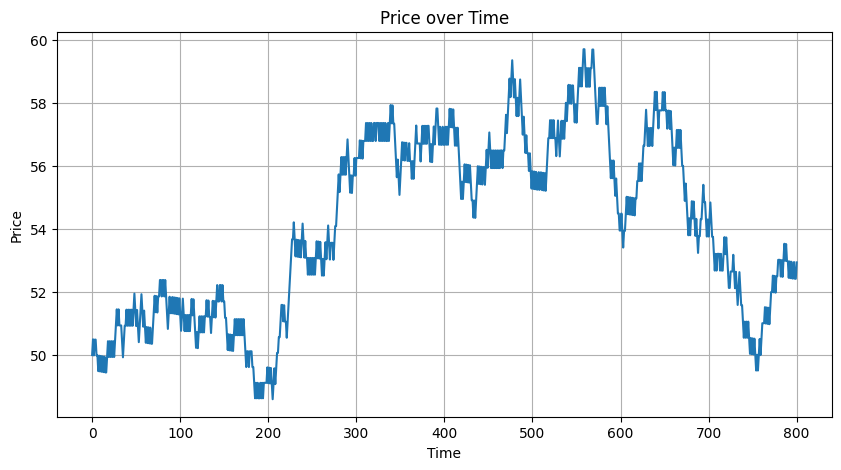

In [116]:
def simulate_market(num_traders, initial_price, time_steps):
    traders = create_traders(num_traders)
    print_trader_counts(traders)
    ph = run_sim(traders, initial_price, [initial_price], time_steps)
    plot_price(ph)

simulate_market(30, 50, 800)

### __Fees__

A first step in making our model more realistic could be accounting for fees. There are various kinds of transaction costs and they can differ quite a bit. For our simulation, let's assume that each trade incurs a transaction fee of 0.75% of the trading amount.

In [117]:
# Add transaction_fee_perc to parameters of execute_trades
def execute_trades(num_matched, buy_orders, sell_orders, transaction_fee_perc):
    # Calculate transaction fee based on transaction price
    transaction_fee = (transaction_fee_perc * price) / 100
    for i in range(num_matched):
        # Add the transaction fee to be subtracted
        buy_orders[i].cash -= (price + transaction_fee)
        buy_orders[i].shares += 1
        # Add the transaction fee to be subtracted
        sell_orders[i].cash += (price - transaction_fee)
        sell_orders[i].shares -= 1
    
    return buy_orders, sell_orders

# Add transaction_fee_perc to parameters
def run_sim(traders, price, price_history, time_steps, transaction_fee_perc):    
    for _ in range(time_steps):
        if (len(price_history) == 1):
            buy_orders, sell_orders = initiate_orders(traders, price, price_history)
        else:    
            buy_orders, sell_orders = initiate_orders(traders, price, price_history[:-1])
             
        num_matched = min(len(buy_orders), len(sell_orders))

        # Add transaction_fee_perc to arguments of execute_trades
        buy_orders, sell_orders = execute_trades(num_matched, buy_orders, sell_orders, transaction_fee_perc)
        price, price_history = adjust_price(buy_orders, sell_orders, num_matched, price, price_history)
    
    return price_history

# Add transaction_fee_perc with default value of 0.75 to parameters of simulate_market
def simulate_market(num_traders, initial_price, time_steps, transaction_fee_perc=0.75):
    traders = create_traders(num_traders)
    print_trader_counts(traders)
    # Add transaction_fee_perc to arguments of run_sim
    ph = run_sim(traders, initial_price, [initial_price], time_steps, transaction_fee_perc)
    plot_price(ph)

### __Initial Trader Wealth__

In real-life, investors don't all start with the same resources - some are richer than others. Let's change each trader's initial __cash__ and __shares__ values to reflect this. 

For simplicity and interest sake, we will make use of UBS' Global Wealth Report of 2024 to distribute the wealth between our traders (see https://www.ubs.com/content/dam/assets/wm/static/noindex/wm-germany/2024/doodownload/Global-Wealth-Report-2024.pdf).

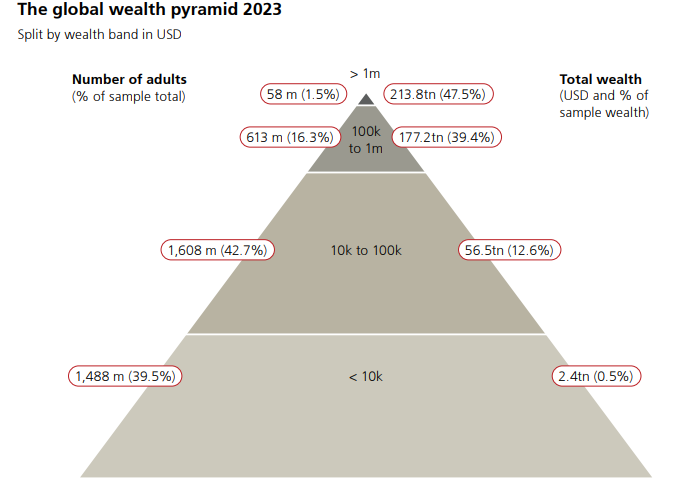

From the above image, we assume the following:
- 1.5% of traders possess 47.5% of the wealth
- 16.3% possess 39.4%
- 42.7% possess 12.6%
- 39.5% possess 0.5%

We will use UBS' intervals and allocate 1m, 550k, 55k, and 10k to our various investors with probabilities 1.5%, 16.3%, 42.7%, and 39.5%, respectively. As a result we also need to change the number of shares that each trader has initially, so that it aligns with our wealth distribution.

In [118]:
import random

class Trader:
    
    # Add a wealth_group attribute to store each trader's wealth group 
    def __init__(self, strategy, cash, shares, wealth_group):
        self.strategy = strategy
        self.cash = cash
        self.shares = shares
        self.wealth_group = wealth_group

    def decide(self, current_price, price_history):
        if self.strategy == 'random':
            return random.choice(['buy', 'sell', 'hold'])
        elif self.strategy == 'momentum':
            if (current_price > price_history[-1]):
                return 'buy'
            elif (current_price < price_history[-1]):
                return 'sell'
            else:
                return 'hold'
        elif self.strategy == 'contrarian':
            if (current_price > price_history[-1]):
                return 'sell'
            elif (current_price < price_history[-1]):
                return 'buy'
            else:
                return 'hold'
            

def create_traders(num_traders, total_shares):   
    strategy_type = [random.choice(['random', 'momentum', 'contrarian']) for _ in range(num_traders)] 

    # Randomly assign wealth groups (initial cash values) to traders according to specific weights
    cash_value = [random.choices([1000000, 550000, 55000, 10000], weights=(1.5, 16.3, 42.7, 39.5), k=1)[0] for _ in range(num_traders)]
    # Calculate the initial instrument price based on total shares and total cash between all traders
    instrument_price = round((sum(cash_value) / total_shares), 2)
    # Number of shares each trader owns at start
    num_shares = [(cash_value[i] // instrument_price) for i in range(num_traders)]
    
    traders = [Trader(strategy_type[i], cash_value[i], num_shares[i], cash_value[i]) for i in range(num_traders)]
    return traders, instrument_price

In our updated __create_traders__ function, we now add __total_shares__ as a parameter and use this to set the initial price of our instrument. Once we have each trader's initial capital and the price of our instrument, we allocate the shares between the traders accordingly. After that we update our main __simulate_market__ and check that it works.

Random traders: 23
Momentum traders: 15
Contrarian trader: 12


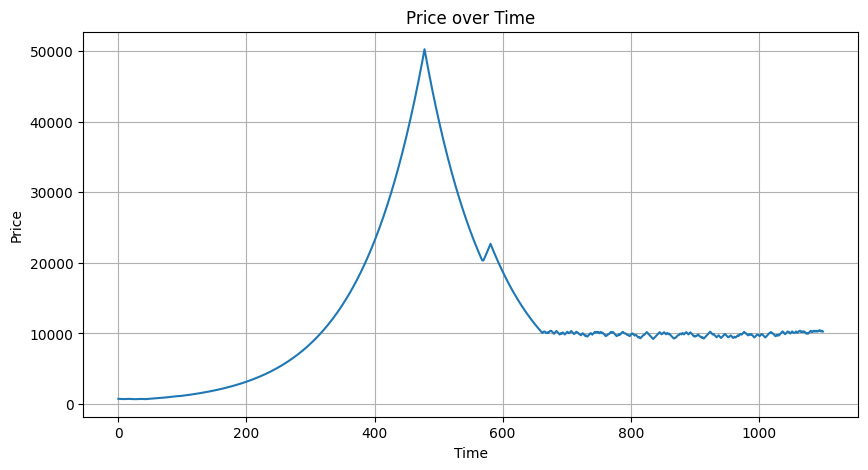

In [119]:
def simulate_market(num_traders, time_steps, transaction_fee_perc=0.75, total_shares=10000):
    traders, initial_price = create_traders(num_traders, total_shares)
    print_trader_counts(traders)
    ph = run_sim(traders, initial_price, [initial_price], time_steps, transaction_fee_perc)
    plot_price(ph)

simulate_market(50, 1100)

### __Tracking Trader Wealth__

It would be interesting to track each of our trader's invested wealth throughout time, that is the value of their shares. A simple way of achieving this is adding a new variable, __share_history__, to our class to store each trader's share value at a particular point in time.

Random traders: 17
Momentum traders: 16
Contrarian trader: 17


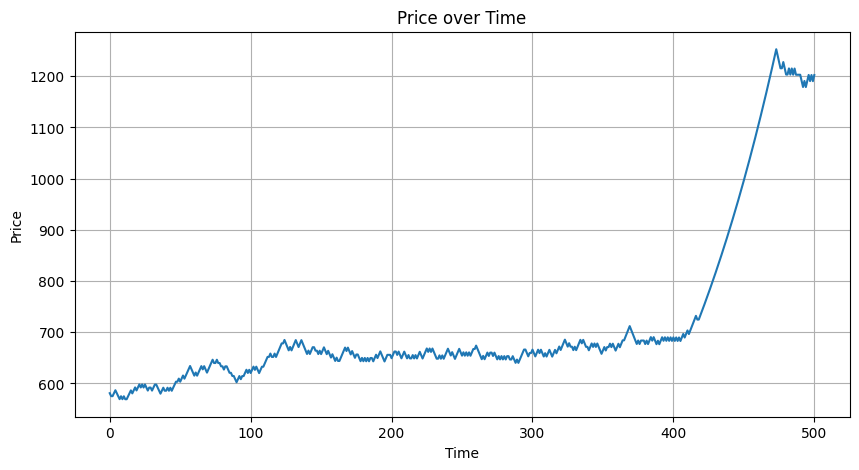

In [120]:
class Trader:
    
    def __init__(self, strategy, cash, shares, wealth_group):
        self.strategy = strategy
        self.cash = cash
        self.shares = shares
        self.wealth_group = wealth_group
        # Add attribute to store number of trader shares at each time-step
        self.share_history = []

    def decide(self, current_price, price_history):
        if self.strategy == 'random':
            return random.choice(['buy', 'sell', 'hold'])
        elif self.strategy == 'momentum':
            if (current_price > price_history[-1]):
                return 'buy'
            elif (current_price < price_history[-1]):
                return 'sell'
            else:
                return 'hold'
        elif self.strategy == 'contrarian':
            if (current_price > price_history[-1]):
                return 'sell'
            elif (current_price < price_history[-1]):
                return 'buy'
            else:
                return 'hold'
            
def initiate_orders(traders, price, price_history):
    buy_orders = []
    sell_orders = []

    for trader in traders:
        # Add new amount of shares to share history
        trader.share_history.append(trader.shares)
        decision = trader.decide(price, price_history)
        if (decision == 'buy') and (trader.cash >= price):
            buy_orders.append(trader)
        elif (decision == 'sell') and (trader.shares > 0):
            sell_orders.append(trader)
    
    random.shuffle(buy_orders)
    random.shuffle(sell_orders)
        
    return buy_orders, sell_orders

def simulate_market(num_traders, time_steps, transaction_fee_perc=0.75, total_shares=10000):
    traders, initial_price = create_traders(num_traders, total_shares)
    print_trader_counts(traders)
    ph = run_sim(traders, initial_price, [initial_price], time_steps, transaction_fee_perc)
    plot_price(ph)

    # Change function to return traders and price history for plotting
    return traders, ph

traders, ph = simulate_market(50, 500)

We can then plot the share histories to compare the performance of our traders.

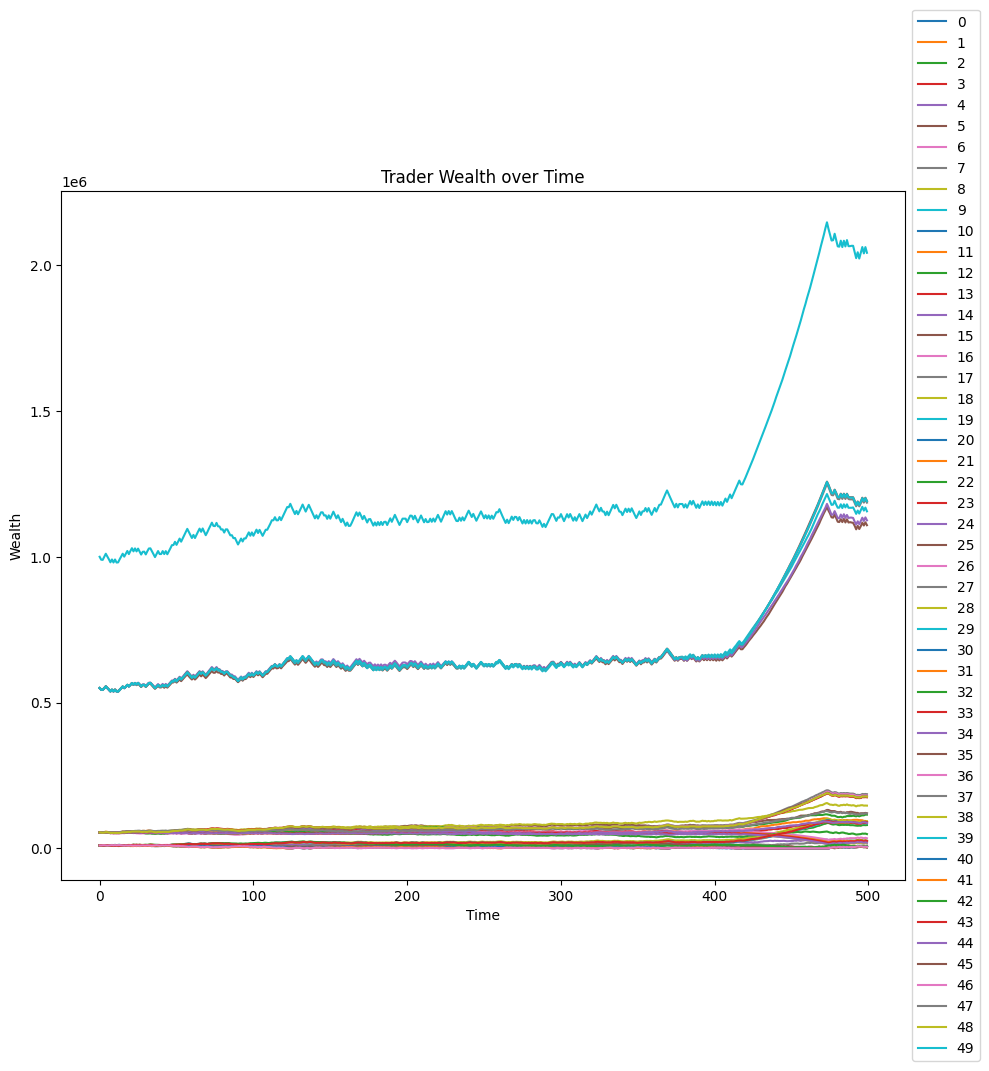

In [121]:
plt.figure(figsize=(10, 10))
lgd = []
for i in range(50):
    # Multiply number of shares with price of share at each time-step for each trader
    share_value = [traders[i].share_history[j] * ph[j] for j in range(len(traders[i].share_history))]
    plt.plot(share_value)
    lgd.append(i)
plt.title(f"Trader Wealth over Time")
plt.ylabel("Wealth")
plt.xlabel("Time")
plt.legend(lgd, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

The above graph might seem odd. The legend shows all our investors, yet we see three/four groups of lines that might not reflect the sort of fluctuations we expect to see. This is because our y-axis (wealth) has a very large range, ~2 million. In fact, the three/four groups of lines we see above represent the four wealth groups we established in our model - 10k, 55k, 550k and 1m. If we were to zoom in on each of these, our results become much clearer.

_*The reason for three/four lines is because we don't always have millionaires in our simulation. Remember, there is only a 1.5% chance of a trader having an initial cash value of 1m._

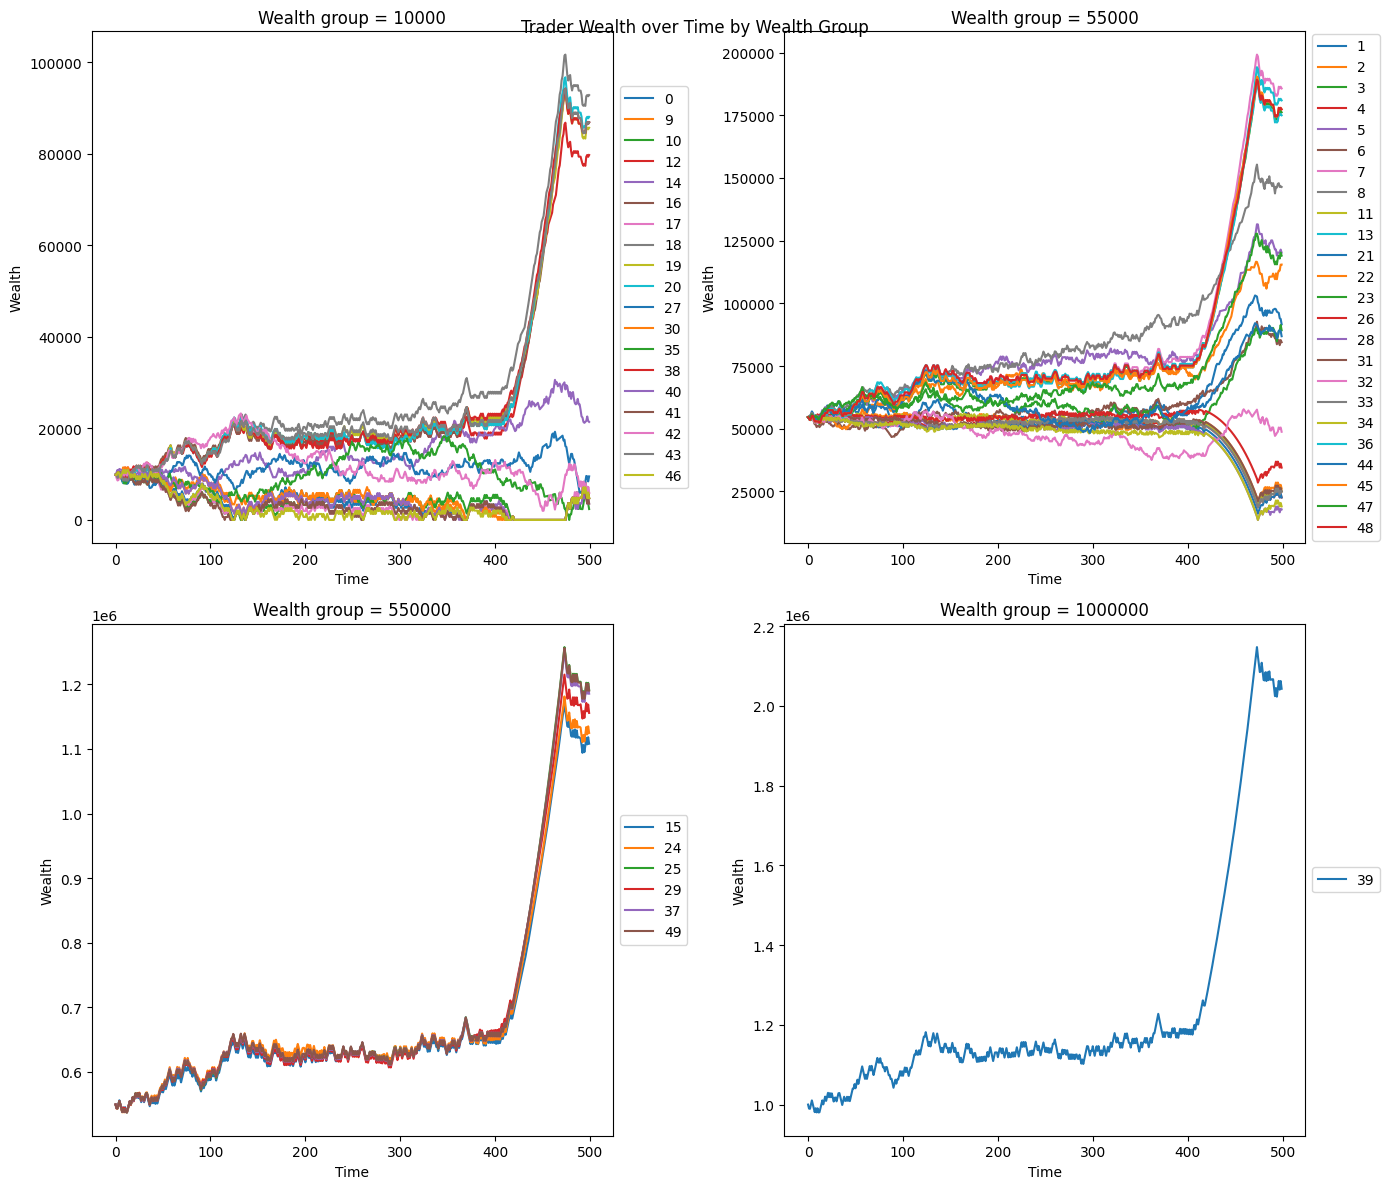

In [122]:
def plot_traders_wealth(traders, group):
    lgd = []
    for i in range(50):
        # Check if trader is part of required wealth group
        if (traders[i].wealth_group == group):
            share_value = [traders[i].share_history[j] * ph[j] for j in range(len(traders[i].share_history))]   
            plt.plot(share_value)
            lgd.append(i)
    plt.title(f"Wealth group = {group}")
    plt.ylabel("Wealth")
    plt.xlabel("Time")
    plt.legend(lgd, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

plt.figure(figsize=(14, 12))

plt.subplot(2,2,1)
plot_traders_wealth(traders, 10000)

plt.subplot(2,2,2)
plot_traders_wealth(traders, 55000)

plt.subplot(2,2,3)
plot_traders_wealth(traders, 550000)

plt.subplot(2,2,4)
plot_traders_wealth(traders, 1000000)

plt.suptitle("Trader Wealth over Time by Wealth Group")
plt.show()


To see the difference between the three possible trading strategies, we can display these four groups differently.

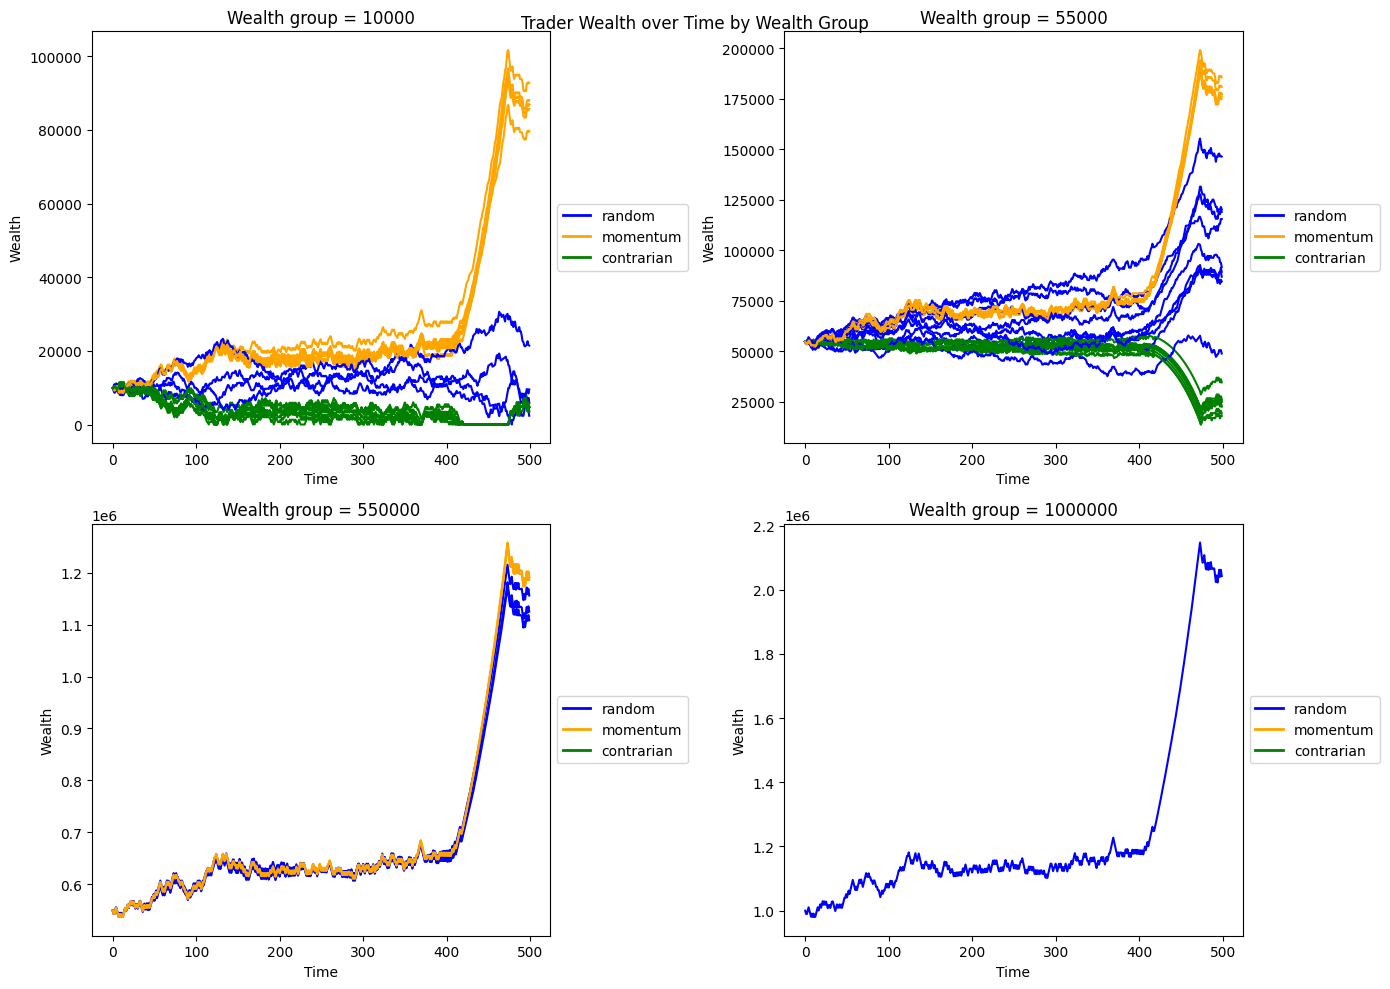

In [123]:
def plot_traders_wealth_strategy(traders, group, num_traders):
    strategy_colors = {
        'random': 'blue',
        'momentum': 'orange',
        'contrarian': 'green'
    }
    
    for i in range(num_traders):
        if (traders[i].wealth_group == group):
            # Assign colour to line based on strategy
            colour = strategy_colors.get(traders[i].strategy, 'black')
            share_value = [traders[i].share_history[j] * ph[j] for j in range(len(traders[i].share_history))]  
            plt.plot(share_value, color=colour)
    plt.title(f"Wealth group = {group}")
    plt.ylabel("Wealth")
    plt.xlabel("Time")
    legend_elements = [plt.Line2D([0], [0], color=color, lw=2, label=strategy) 
                      for strategy, color in strategy_colors.items()]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plot_traders_wealth_strategy(traders, 10000, 50)

plt.subplot(2,2,2)
plot_traders_wealth_strategy(traders, 55000, 50)

plt.subplot(2,2,3)
plot_traders_wealth_strategy(traders, 550000, 50)

plt.subplot(2,2,4)
plot_traders_wealth_strategy(traders, 1000000, 50)

plt.suptitle("Trader Wealth over Time by Wealth Group")
plt.show()

### __Interpreting Our Results__

The results shown in our visual plots may vary drastically for each simulation, but it seems clear (especially from the higher wealth groups) that the total wealth of our traders follows the instrument price fairly closely over time. If the share price rises (falls), the value of a trader's shares rises (falls). The misalignment between the price graph and the lower wealth groups' plots could be caused by a number of factors:
- Richer groups begin with more shares, meaning the value of their holdings is dominated by the instrument price itself. Therefore, fluctuations in price have a large absolute effect on their total wealth.
- Poorer groups are most likely more sensitive to the transaction fees and liquidity contraints, i.e., they don't always have the required cash/share amount to buy/sell when they want to. 

Currently, we have 10,000 shares between everyone, but if we increased the total number of shares in circulation so that even the poorer groups have lots to start with (say 500,000), we see that their plots more closely resemble the price of the instrument over time.

Random traders: 20
Momentum traders: 16
Contrarian trader: 14


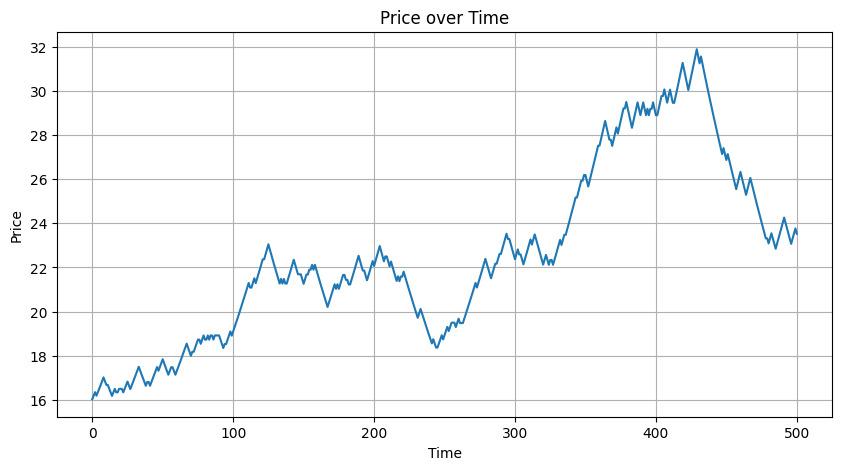

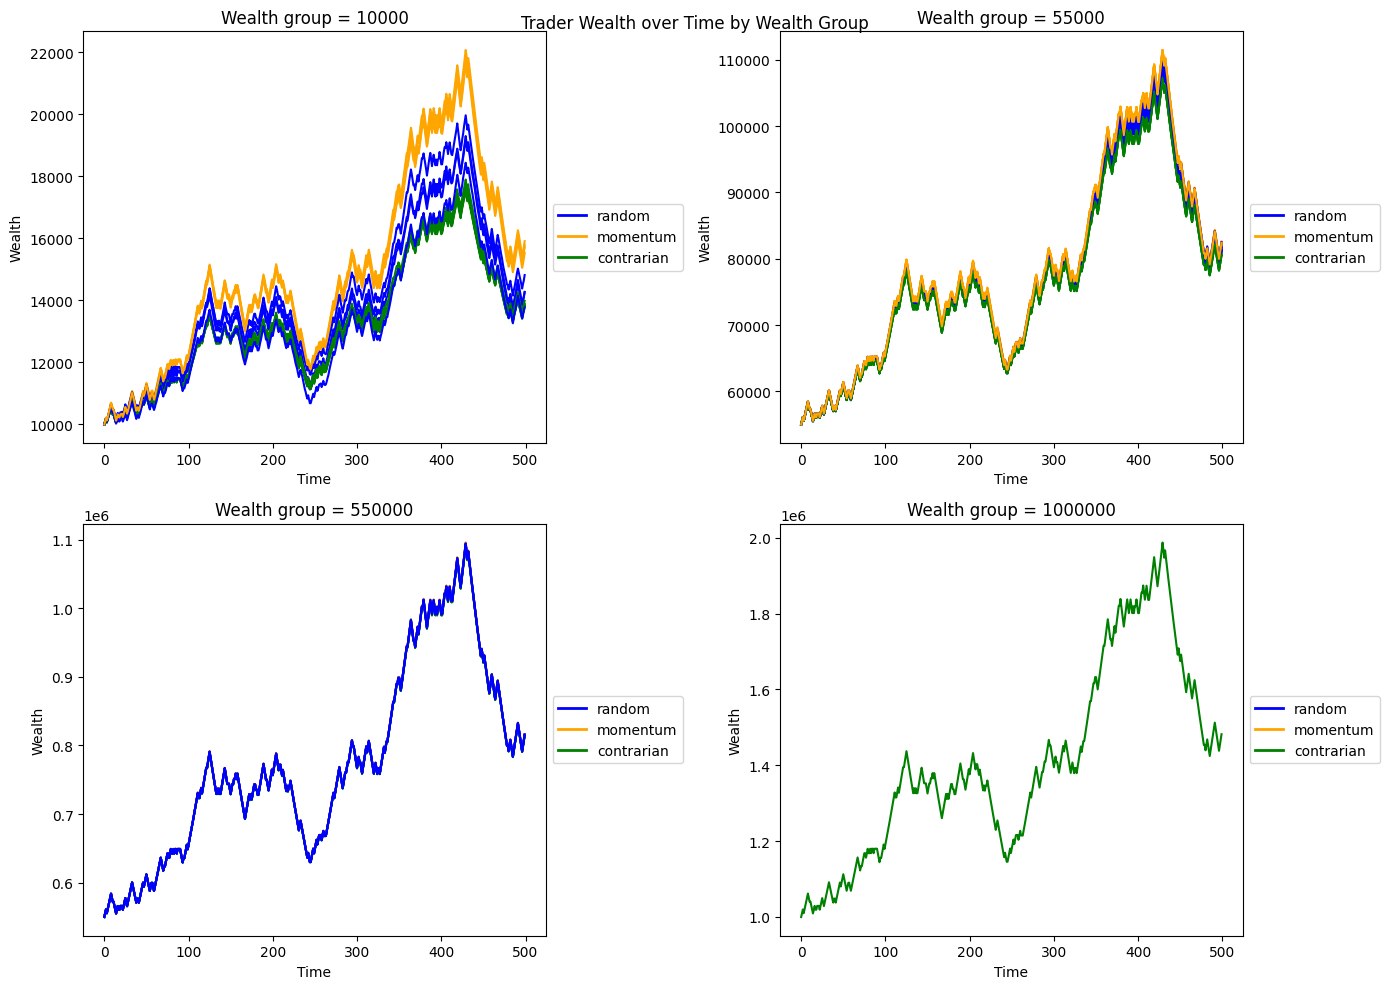

In [124]:
traders, ph = simulate_market(50, 500, 0.75, 500000)

plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plot_traders_wealth_strategy(traders, 10000, 50)

plt.subplot(2,2,2)
plot_traders_wealth_strategy(traders, 55000, 50)

plt.subplot(2,2,3)
plot_traders_wealth_strategy(traders, 550000, 50)

plt.subplot(2,2,4)
plot_traders_wealth_strategy(traders, 1000000, 50)

plt.suptitle("Trader Wealth over Time by Wealth Group")
plt.show()

This confirms the obvious insight: _the more an investor owns of a particular share, the greater the effect of share price fluctuations on the investor's total wealth_.*

The shapes seen in our plots are also caused by the fact that all traders are only capable of buying or selling a single share at each time-step. Additionally, traders with the same strategy will buy/sell at every possible time interval, which isn't true in reality. Most investors don't constantly watch the market and buy or sell every day.

There are two features we should add to rectify this behaviour we see in the plots:
1. Add an element of randomness regarding when a trader trades
2. Allow traders to trade variable amounts worth of shares

_*Less obvious, perhaps, is that a trader's strategy becomes more irrelevant the more shares a trader owns (in terms of share value). This, however, is only the case for our model at the moment._

### __Varying When a Trader Trades__

To achieve this, we can alter our original class __Trader__ to decide only at certain time-steps, for example only 30% of the time.

In [125]:
class Trader:
    
    def __init__(self, strategy, cash, shares, wealth_group):
        self.strategy = strategy
        self.cash = cash
        self.shares = shares
        self.wealth_group = wealth_group
        self.share_history = []

    def decide(self, current_price, price_history):
        # Add extra condition to simulate a trader only trading 30% of the time
        if random.random() <= 0.3:
            if self.strategy == 'random':
                return random.choice(['buy', 'sell', 'hold'])
            elif self.strategy == 'momentum':
                if (current_price > price_history[-1]):
                    return 'buy'
                elif (current_price < price_history[-1]):
                    return 'sell'
                else:
                    return 'hold'
            elif self.strategy == 'contrarian':
                if (current_price > price_history[-1]):
                    return 'sell'
                elif (current_price < price_history[-1]):
                    return 'buy'
                else:
                    return 'hold'
        return 'hold'

### __Varying How Many Shares a Trader Trades__

This step is a bit more involved because we need to make changes everywhere that shares are involved. 

The first place will be our __initiate_orders__ function, where we determine which traders want to buy and which want to sell. Now, we need to add how many shares they want to trade, as well. For the buyers, we create a __decision_shares_to_buy__ variable that stores a random number of shares a buyer wants to buy. For our model, we'll make it so that a trader can't spend more than 20% of their cash per time-step, but you can change this. We then add each trader, as well as the number of shares they want to buy, to our __buy_orders__ object. For the sellers we do exactly the same - permitting them to sell at most 20% of their shares per time-step - and add the information to __sell_orders__.

Once we know how many shares traders want to buy and sell, we use this in a new function, __find_num_matched_traders__, to determine how many shares will be bought and sold. So, we still need to match supply and demand, but now we consider total number of shares, and not just number of buyers/sellers. For example, let's say we have the following:

- 12 traders want to buy a total of 50 shares
- 9 traders want to sell a total of 43 shares

We know that only 43 shares will be traded, and the remaining demand of 7 shares means our price will increase. We know all 9 traders will sell their shares, but which buyer(s) won't able to buy those 7 outstanding shares? This is exactly what our function calculates. It then returns all matched buyers and sellers, as well as how many shares they will buy or sell (this will equal 43 in our example).

Next, we update our __execute_trades__ function. We need to account for the number of shares being bought/sold by each trader, and adjust how their __cash__ and __shares__ values are updated.

Finally, in our __adjust_price__ function, we make the necessary changes to adjust price based on unmatched shares, and not on unmatched traders.


Random traders: 19
Momentum traders: 13
Contrarian trader: 18


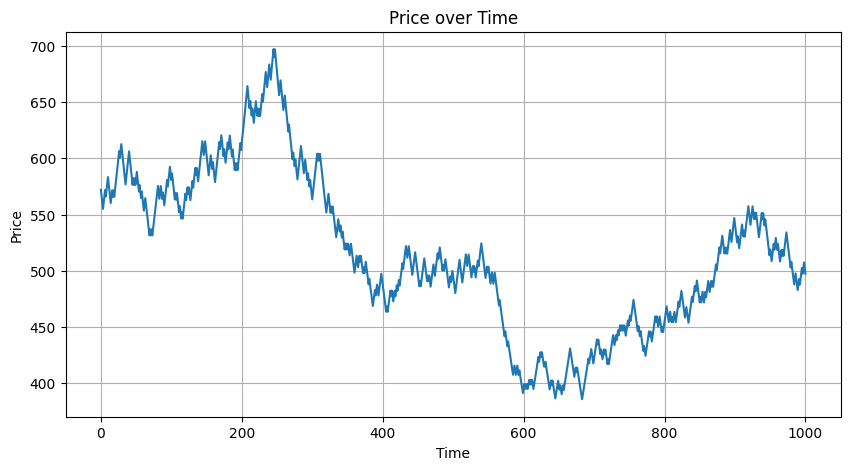

In [126]:
# Our new initiate_orders function will now return those who wish to trade, as well as how many shares they wish to trade
def initiate_orders(traders, price, price_history):
    buy_orders = []
    sell_orders = []

    for trader in traders:
        trader.share_history.append(trader.shares)
        decision = trader.decide(price, price_history)
        if (decision == 'buy'):
            if trader.cash >= price:
                # Number of shares a trader decides to buy - can't buy more than 20% of traders cash
                decision_shares_to_buy = round(random.uniform(0, 0.2) * (trader.cash / price))
                # Ensure they buy at least 1 (floor)
                decision_shares_to_buy = max(1, decision_shares_to_buy)           
                # Add both trader and the number of shares they wish to buy to buy order
                buy_orders.append([trader, decision_shares_to_buy])
        elif (decision == 'sell') and (trader.shares > 0):
            if trader.shares > 0:
                # Number of shares a trader decides to sell - can't buy more than 20% of traders shares
                decision_shares_to_sell = round(random.uniform(0, 0.2) * trader.shares)
                # Ensure they sell at least 1 (floor)
                decision_shares_to_sell = max(1, decision_shares_to_sell) 
                # Add both trader and the number of shares they wish to sell to sell order 
                sell_orders.append([trader, decision_shares_to_sell]) 

    random.shuffle(buy_orders)
    random.shuffle(sell_orders)
        
    return buy_orders, sell_orders

# Update function to accomodate variable number of shares that traders want to buy and sell
def find_num_matched_traders(buy_orders, sell_orders, num_matched):

    # Create copies of buy and sell orders to use within function to prevent altering global buy and sell orders
    buy_orders_temp = buy_orders[:]
    sell_orders_temp = sell_orders[:]
    
    running_buy_shares = 0 # number of shares that will be bought
    running_sell_shares = 0 # number of shares that will be sold
    
    # stores buyers who have sellers, as well as the number of shares they will buy
    matched_buyers = []    
    # stores seller who have buyers, as well as the number of shares they will sell
    matched_sellers = []

    # while there are still buyers and shares left to be bought
    while buy_orders_temp and running_buy_shares < num_matched:
        # find first trader that wants to buy and remove from buyer list
        trader, num_shares_to_buy = buy_orders_temp.pop(0)
        # add number of shares buyer wants to buy to number of shares that will be bought
        running_buy_shares += num_shares_to_buy
        # add trader and number of shares they want to buy to matched_buyers
        matched_buyers.append([trader, num_shares_to_buy])
    
    # final matched buyer might want to buy more shares than are available, so remove the difference
    # and only allow them to buy remaining number of shares
    if (running_buy_shares > num_matched):
        matched_buyers[-1][1] -= (running_buy_shares - num_matched)

    # while there are still sellers and shares left to be sold
    while sell_orders_temp and running_sell_shares < num_matched:
        # find first trader that wants to sell and remove from seller list
        trader, num_shares_to_sell = sell_orders_temp.pop(0)
        # add number of shares seller wants to sell to number of shares that will be sold
        running_sell_shares += num_shares_to_sell
        # add trader and number of shares they want to sell to matched_sellers
        matched_sellers.append([trader, num_shares_to_sell])
    
    # final matched seller might want to sell more shares than are available, so remove the difference
    # and only allow them to sell remaining number of shares
    if (running_sell_shares > num_matched):
        matched_sellers[-1][1] -= (running_sell_shares - num_matched)
    
    return matched_buyers, matched_sellers

def execute_trades(matched_buyers, matched_sellers, price, transaction_fee_perc):
    
    # Add buyer[1] in equation to account for number of shares buyer wants to buy
    for buyer in matched_buyers:
        transaction_fee = (transaction_fee_perc * price * buyer[1]) / 100 
        buyer[0].cash -= (price * buyer[1] + transaction_fee)
        buyer[0].shares += buyer[1]
    
    # Add seller[1] in equation to account for number of shares seller wants to sell
    for seller in matched_sellers:
        transaction_fee = (transaction_fee_perc * price * seller[1]) / 100 
        seller[0].cash += (price * seller[1] - transaction_fee)
        seller[0].shares -= seller[1]

def adjust_price(num_matched, price, price_history, total_buy_shares, total_sell_shares):
    
    # Remaining number of shares buyers wanted to buy
    unmatched_demand = total_buy_shares - num_matched
    # Remaining number of shares sellers wanted to sell
    unmatched_supply = total_sell_shares - num_matched

    if unmatched_demand > unmatched_supply:
        price *= 1.01
    elif unmatched_supply > unmatched_demand:
        price *= 0.99

    price = round(price, 2)
    price_history.append(price)

    return price, price_history

def run_sim(traders, price, price_history, time_steps, transaction_fee_perc):    
    for _ in range(time_steps):
        if (len(price_history) == 1):
            buy_orders, sell_orders = initiate_orders(traders, price, price_history)
        else:    
            buy_orders, sell_orders = initiate_orders(traders, price, price_history[:-1])    
        
        # total number of shares buyers want to buy
        total_buy_shares = sum(buy_orders[i][1] for i in range(len(buy_orders)))
        # total number of shares sellers want to sell
        total_sell_shares = sum(sell_orders[i][1] for i in range(len(sell_orders)))  

        num_matched = min(total_buy_shares, total_sell_shares)
        # Find buyers who have sellers and vice versa
        matched_buyers, matched_sellers = find_num_matched_traders(buy_orders, sell_orders, num_matched)

        # Only execute trades if there are traders who have been matched
        if num_matched > 0:
            execute_trades(matched_buyers, matched_sellers, price, transaction_fee_perc)
        # Update price only on excess number of shares to be bought or sold
        price, price_history = adjust_price(num_matched, price, price_history, total_buy_shares, total_sell_shares)
    
    return price_history

traders, ph = simulate_market(50, 1000, 0.75, 10000)

If we look at our wealth over time plots again, we see that the general alignment with share price has disappeared, and the lines in each plot seem much more frantic. This is because a trader can now trade various amounts of money at every time-step, so their wealth won't always go up or down by only 1 unit per time interval. Additionally, traders of the same type no longer make the exact same trades at the same time, since we added an element of randomness to when each trader buys or sells.

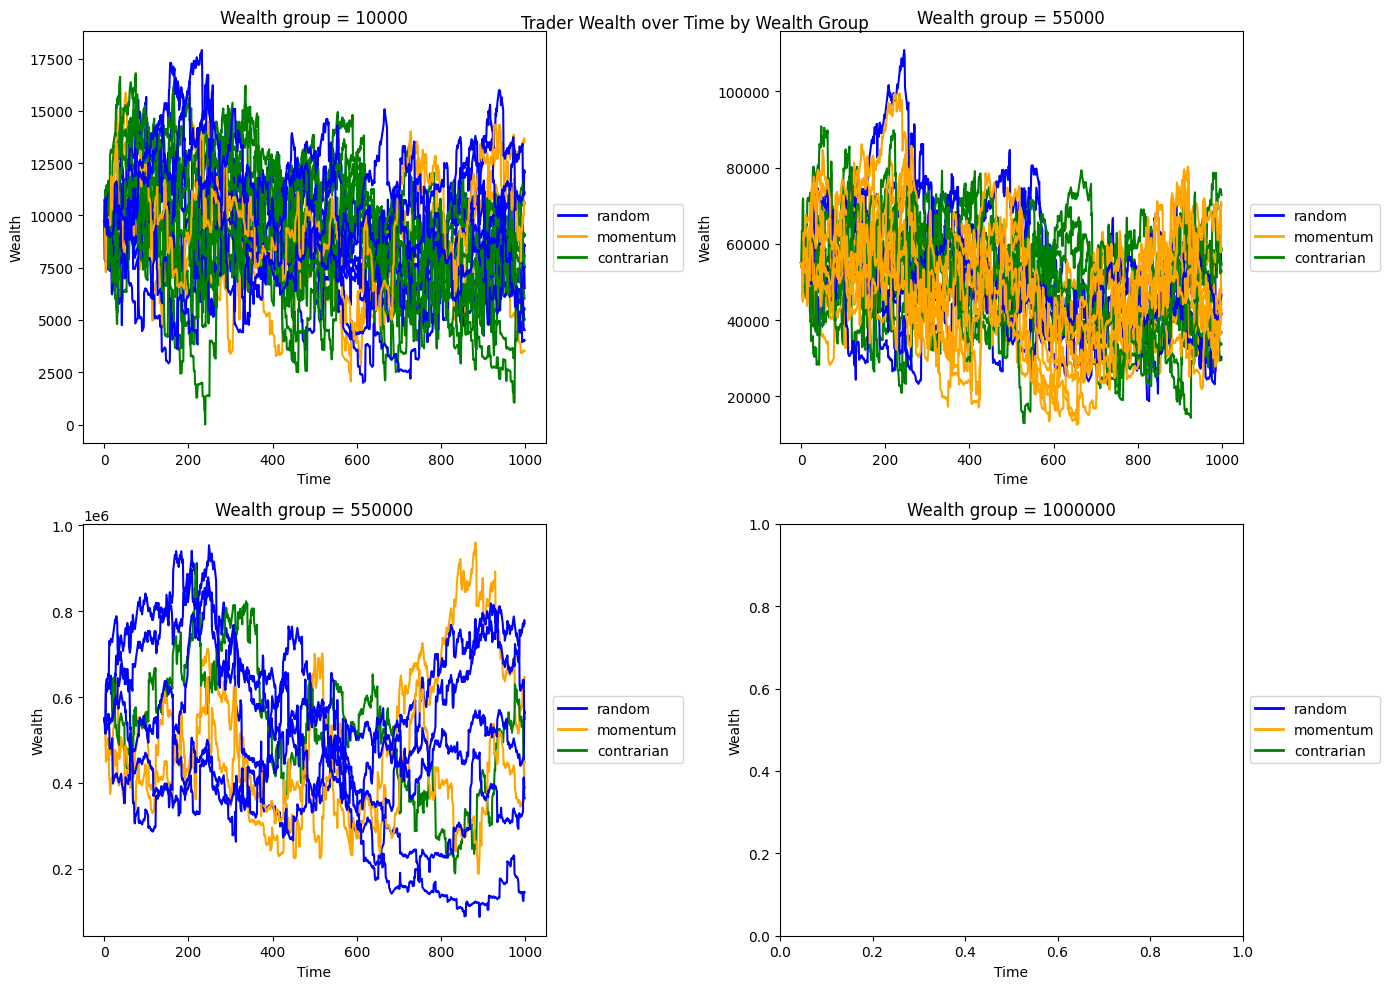

In [127]:
plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plot_traders_wealth_strategy(traders, 10000, 50)

plt.subplot(2,2,2)
plot_traders_wealth_strategy(traders, 55000, 50)

plt.subplot(2,2,3)
plot_traders_wealth_strategy(traders, 550000, 50)

plt.subplot(2,2,4)
plot_traders_wealth_strategy(traders, 1000000, 50)

plt.suptitle("Trader Wealth over Time by Wealth Group")
plt.show()

### __Refining Price Changes__

As it stands, our instrument price changes by a single percentage point at each time-step. This price update is based on the imbalance between unmatched buyers and sellers after matching trades. Although a simple and reasonable way to model price changes, let's try and make it more realistic.

As a first step, our aim is to change the price relative to the degree of demand or supply. If the demand is much greater than supply, then the increase in price will be larger than if the demand were only a little greater than supply. To implement this, we change our __adjust_price__ function to calculate the total unmatched supply and demand (the total shares that traders still want to sell/buy after buyers and sellers have been matched), and we use this to obtain an _imbalance_ value. For our model, we can divide this value by the total number of participating traders (at a given time-step) to obtain a measure of how much the price should change*.

In the code below you will also notice a introduction of a so-called _floor_ for our price, which we have selected to be 1. This is simply to ensure that the price of our instrument can never be zero.

_*This way of adjusting the prices might be a bit overengineered for our small sim - feel free to play around with it. For interest sake, the mechanism driving real-time price changes in financial markets are order books._

Random traders: 16
Momentum traders: 17
Contrarian trader: 17


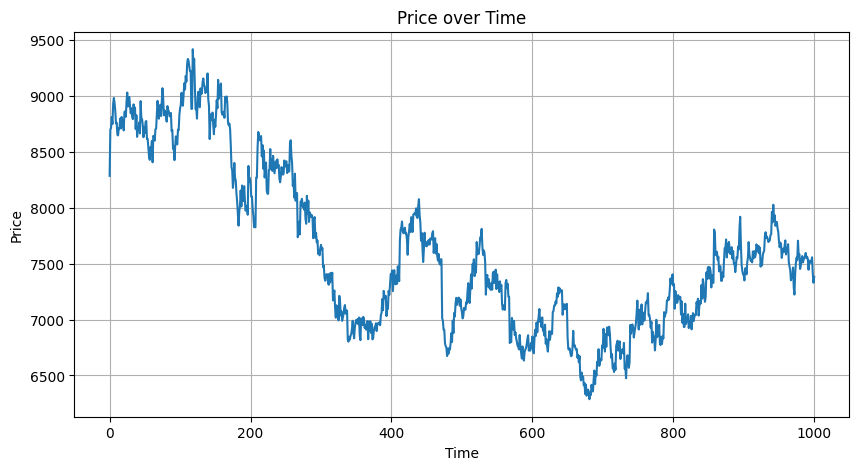

In [128]:
# Updated parameters of function adjust_price
def adjust_price(buy_orders, sell_orders, matched_buyers, matched_sellers, price, price_history, total_buy_shares, total_sell_shares):
        
    # number of shares actually bought at execution
    matched_demand = sum([matched_buyers[i][1] for i in range(len(matched_buyers))])
    # number of shares actually sold at execution
    matched_supply = sum([matched_sellers[i][1] for i in range(len(matched_sellers))])
    
    # number of shares that still want to be bought
    unmatched_demand = total_buy_shares - matched_demand
    # number of shares that still want to be sold
    unmatched_supply = total_sell_shares - matched_supply

    imbalance = unmatched_demand - unmatched_supply
    total_trading_traders = len(buy_orders) + len(sell_orders) # total participating traders

    # if demand and supply not in equilibrium (if so, price will remain the same)
    if imbalance != 0:
        # add factor of 0.01 to constrain impact of imbalance on price change
        price *= (1 + 0.01 * imbalance / total_trading_traders)

    price = round(price, 2)
    price = max(1, price) # floor
    price_history.append(price)

    return price, price_history

def run_sim(traders, price, price_history, time_steps, transaction_fee_perc):    
    for _ in range(time_steps):
        if (len(price_history) == 1):
            buy_orders, sell_orders = initiate_orders(traders, price, price_history)
        else:    
            buy_orders, sell_orders = initiate_orders(traders, price, price_history[:-1]) 
        
        total_buy_shares = sum(buy_orders[i][1] for i in range(len(buy_orders)))
        total_sell_shares = sum(sell_orders[i][1] for i in range(len(sell_orders)))  

        num_matched = min(total_buy_shares, total_sell_shares)
        matched_buyers, matched_sellers = find_num_matched_traders(buy_orders, sell_orders, num_matched)

        if num_matched > 0:
            execute_trades(matched_buyers, matched_sellers, price, transaction_fee_perc)
        # updated arguments to function adjust_price
        price, price_history = adjust_price(buy_orders, sell_orders, matched_buyers, matched_sellers, price, price_history, total_buy_shares, total_sell_shares)
    
    return price_history

traders, ph = simulate_market(50, 1000, 0.75, 1000)

### __The End (for now)__

At this point it might be worth taking a step back. There remains a whole host of features we can add, but we've come a long way in achieving our goal of simulating the market for a financial instrument. We've simulated traders who use different strategies to buy and sell variable units of the instrument at various time-steps, thus affecting the instrument price.

Below you will find the complete outline of our model, that may be used as a base for you to chop and change as you please.

Random traders: 14
Momentum traders: 15
Contrarian trader: 21


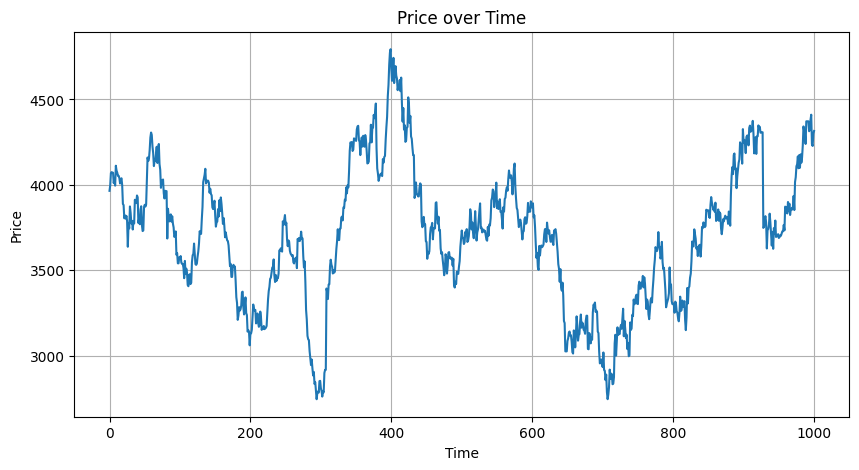

In [129]:
import random
import matplotlib.pyplot as plt

class Trader:    

    def __init__(self, strategy, cash, shares, wealth_group):
        self.strategy = strategy
        self.cash = cash
        self.shares = shares
        self.wealth_group = wealth_group
        self.share_history = []

    def decide(self, current_price, price_history):
        if random.random() <= 0.3:
            if self.strategy == 'random':
                return random.choice(['buy', 'sell', 'hold'])
            elif self.strategy == 'momentum':
                if (current_price > price_history[-1]):
                    return 'buy'
                elif (current_price < price_history[-1]):
                    return 'sell'
                else:
                    return 'hold'
            elif self.strategy == 'contrarian':
                if (current_price > price_history[-1]):
                    return 'sell'
                elif (current_price < price_history[-1]):
                    return 'buy'
                else:
                    return 'hold'
        return 'hold'
    
    def create_traders(num_traders, total_shares):   

        strategy_type = [random.choice(['random', 'momentum', 'contrarian']) for _ in range(num_traders)] 
        cash_value = [random.choices([1000000, 550000, 55000, 10000], weights=(1.5, 16.3, 42.7, 39.5), k=1)[0] for _ in range(num_traders)]
        instrument_price = round((sum(cash_value) / total_shares), 2)
        num_shares = [(cash_value[i] // instrument_price) for i in range(num_traders)]        
        traders = [Trader(strategy_type[i], cash_value[i], num_shares[i], cash_value[i]) for i in range(num_traders)]

        return traders, instrument_price
    
    def print_trader_counts(traders):
        ran_trader_count = 0
        mom_trader_count = 0
        con_trader_count = 0

        for trader in traders:
            if trader.strategy == 'random': ran_trader_count += 1
            elif trader.strategy == 'momentum': mom_trader_count += 1
            else: con_trader_count += 1

        print(f'Random traders: {ran_trader_count}')
        print(f'Momentum traders: {mom_trader_count}')
        print(f'Contrarian trader: {con_trader_count}')

def initiate_orders(traders, price, price_history):
    buy_orders = []
    sell_orders = []

    for trader in traders:
        trader.share_history.append(trader.shares)
        decision = trader.decide(price, price_history)

        if (decision == 'buy'):
            if trader.cash >= price:
                decision_shares_to_buy = round(random.uniform(0, 0.2) * (trader.cash / price))
                decision_shares_to_buy = max(1, decision_shares_to_buy)           
                buy_orders.append([trader, decision_shares_to_buy])
        elif (decision == 'sell') and (trader.shares > 0):
            if trader.shares > 0:
                decision_shares_to_sell = round(random.uniform(0, 0.2) * trader.shares)
                decision_shares_to_sell = max(1, decision_shares_to_sell)  
                sell_orders.append([trader, decision_shares_to_sell]) 

    random.shuffle(buy_orders)
    random.shuffle(sell_orders)
        
    return buy_orders, sell_orders

def find_num_matched_traders(buy_orders, sell_orders, num_matched):
    
    buy_orders_temp = buy_orders[:]
    sell_orders_temp = sell_orders[:]
    running_buy_shares = 0
    running_sell_shares = 0
    matched_buyers = []    
    matched_sellers = []

    while buy_orders_temp and running_buy_shares < num_matched:
        trader, num_shares_to_buy = buy_orders_temp.pop()
        running_buy_shares += num_shares_to_buy
        matched_buyers.append([trader, num_shares_to_buy])
    
    if (running_buy_shares > num_matched):
        matched_buyers[-1][1] -= (running_buy_shares - num_matched)

    while sell_orders_temp and running_sell_shares < num_matched:
        trader, num_shares_to_sell = sell_orders_temp.pop(0)
        running_sell_shares += num_shares_to_sell
        matched_sellers.append([trader, num_shares_to_sell])
    
    if (running_sell_shares > num_matched):
        matched_sellers[-1][1] -= (running_sell_shares - num_matched)
    
    return matched_buyers, matched_sellers

def execute_trades(matched_buyers, matched_sellers, price, transaction_fee_perc):
    for buyer in matched_buyers:
        transaction_fee = (transaction_fee_perc * price * buyer[1]) / 100 
        buyer[0].cash -= (price * buyer[1] + transaction_fee)
        buyer[0].shares += buyer[1]
    
    for seller in matched_sellers:
        transaction_fee = (transaction_fee_perc * price * seller[1]) / 100 
        seller[0].cash += (price * seller[1] - transaction_fee)
        seller[0].shares -= seller[1]

def adjust_price(buy_orders, sell_orders, matched_buyers, matched_sellers, price, price_history, total_buy_shares, total_sell_shares):
    
    matched_demand = sum([matched_buyers[i][1] for i in range(len(matched_buyers))])
    matched_supply = sum([matched_sellers[i][1] for i in range(len(matched_sellers))])
    
    unmatched_demand = total_buy_shares - matched_demand
    unmatched_supply = total_sell_shares - matched_supply

    imbalance = unmatched_demand - unmatched_supply
    total_trading_traders = len(buy_orders) + len(sell_orders)

    if imbalance != 0:
        price *= (1 + 0.01 * imbalance / total_trading_traders)

    price = round(price, 2)
    price = max(1, price)
    price_history.append(price)

    return price, price_history

def run_sim(traders, price, price_history, time_steps, transaction_fee_perc):   

    for _ in range(time_steps):
        if (len(price_history) == 1):
            buy_orders, sell_orders = initiate_orders(traders, price, price_history)
        else:    
            buy_orders, sell_orders = initiate_orders(traders, price, price_history[:-1])    
        
        total_buy_shares = sum(buy_orders[i][1] for i in range(len(buy_orders)))
        total_sell_shares = sum(sell_orders[i][1] for i in range(len(sell_orders)))  

        num_matched = min(total_buy_shares, total_sell_shares)
        matched_buyers, matched_sellers = find_num_matched_traders(buy_orders, sell_orders, num_matched)

        if num_matched > 0:
            execute_trades(matched_buyers, matched_sellers, price, transaction_fee_perc)

        price, price_history = adjust_price(buy_orders, sell_orders, matched_buyers, matched_sellers, price, price_history, total_buy_shares, total_sell_shares)
    
    return price_history

def plot_price(price_history):
    plt.figure(figsize=(10, 5))
    plt.plot(price_history)
    plt.title("Price over Time")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

def simulate_market(num_traders, time_steps, transaction_fee_perc=0.75, total_shares=1000):

    traders, initial_price = create_traders(num_traders, total_shares)
    print_trader_counts(traders)
    ph = run_sim(traders, initial_price, [initial_price], time_steps, transaction_fee_perc)
    plot_price(ph)

    return traders, ph

traders, ph = simulate_market(50, 1000)